In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path

# --------- small residual block (no norm; astronomy likes no BN) ----------
class ResBlock(nn.Module):
    def __init__(self, ch, bottleneck=0):
        super().__init__()
        mid = ch if bottleneck <= 0 else bottleneck
        self.conv1 = nn.Conv2d(ch, mid, 3, padding=1)
        self.act   = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(mid, ch, 3, padding=1)
    def forward(self, x):
        y = self.conv2(self.act(self.conv1(x)))
        return x + y * 0.2   # small residual scaling for stability

# --------- Generator: UNetish, same H×W in/out, 1→1 channels ----------
class SatGANGenerator(nn.Module):
    def __init__(self, in_ch=1, ch=64, depth=3, res_per_stage=2):
        super().__init__()
        self.head = nn.Conv2d(in_ch, ch, 3, padding=1)
        # down
        self.down1 = nn.Sequential(*[ResBlock(ch) for _ in range(res_per_stage)], nn.Conv2d(ch, ch*2, 3, stride=2, padding=1))
        self.down2 = nn.Sequential(*[ResBlock(ch*2) for _ in range(res_per_stage)], nn.Conv2d(ch*2, ch*4, 3, stride=2, padding=1))
        # bottleneck
        self.mid = nn.Sequential(*[ResBlock(ch*4) for _ in range(res_per_stage+1)])
        # up
        self.up2  = nn.ConvTranspose2d(ch*4, ch*2, 4, stride=2, padding=1)
        self.rb2  = nn.Sequential(*[ResBlock(ch*2) for _ in range(res_per_stage)])
        self.up1  = nn.ConvTranspose2d(ch*2, ch, 4, stride=2, padding=1)
        self.rb1  = nn.Sequential(*[ResBlock(ch) for _ in range(res_per_stage)])
        # tail
        self.tail = nn.Conv2d(ch, 1, 3, padding=1)
    def forward(self, x):
        x0 = self.head(x)           # [B,64,H,W]
        d1 = self.down1(x0)         # [B,128,H/2,W/2]
        d2 = self.down2(d1)         # [B,256,H/4,W/4]
        m  = self.mid(d2)           # [B,256,H/4,W/4]
        u2 = self.rb2(self.up2(m) + d1)
        u1 = self.rb1(self.up1(u2) + x0)
        # out = torch.sigmoid(self.tail(u1))  # map to [0,1]
        out = self.tail(u1) 
        return out

# --------- Patch Discriminator (hinge), spectral norm ----------
def snconv(c_in, c_out, k, s=1, p=0):
    return nn.utils.spectral_norm(nn.Conv2d(c_in, c_out, k, stride=s, padding=p))

class PatchDiscriminator(nn.Module):
    def __init__(self, in_ch=1, ch=64):
        super().__init__()
        self.net = nn.Sequential(
            snconv(in_ch, ch,   3, 1, 1), nn.LeakyReLU(0.2, inplace=True),
            snconv(ch,   ch,    4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            snconv(ch,   ch*2,  3, 1, 1), nn.LeakyReLU(0.2, inplace=True),
            snconv(ch*2, ch*2,  4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            snconv(ch*2, ch*4,  3, 1, 1), nn.LeakyReLU(0.2, inplace=True),
            snconv(ch*4, ch*4,  4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            snconv(ch*4, 1,     3, 1, 1) # Patch logits
        )
    def forward(self, x):  # x in [0,1]
        return self.net(x)


In [2]:
# cell: setup
import os, json, math, numpy as np, torch, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from typing import Optional
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

try:
    # newer AMP API (avoid the deprecation warnings)
    from torch.amp import autocast, GradScaler
    AMP_DEVICE = "cuda" if DEVICE.startswith("cuda") else "cpu"
    scaler = GradScaler(AMP_DEVICE)
except Exception:
    from torch.cuda.amp import autocast, GradScaler
    scaler = GradScaler(enabled=(DEVICE.startswith("cuda")))
    AMP_DEVICE = "cuda"

torch.backends.cudnn.benchmark = True
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass


In [3]:
# cell: PSF kernel (the one you saved during dataset generation)

KERNEL_NPY = "lsst_psf_fwhm0p7_beta3p5_pix0.110.npy"  # <- set to your saved filename

kernel_np = np.load(KERNEL_NPY).astype(np.float32)
assert kernel_np.ndim == 2, kernel_np.shape
kernel_t = torch.from_numpy(kernel_np)[None, None]      # [1,1,kh,kw]
kernel_t = kernel_t / kernel_t.sum()
kernel_t = kernel_t.to(DEVICE)

kh, kw = kernel_t.shape[-2:]
pad_h, pad_w = kh//2, kw//2

# --- PSF tools ---
def center_crop_psf(psf: torch.Tensor, target_h: int, target_w: int) -> torch.Tensor:
    """psf: [1,1,kh,kw], returns center crop to [1,1,target_h,target_w] (keeps sum=1)."""
    _, _, kh, kw = psf.shape
    assert target_h <= kh and target_w <= kw
    top  = (kh - target_h) // 2
    left = (kw - target_w) // 2
    out = psf[:, :, top:top+target_h, left:left+target_w].contiguous()
    return out / out.sum()

_psf_cache = {}  # key: (H,W) -> (kernel, pad_h, pad_w)

def get_psf_for_size(H: int, W: int, device=None):
    """
    Ensure reflect padding is valid:
      pad_h = floor(kh/2) <= H-1  -> kh <= 2H-1 (if kh odd), <= 2H-2 (if kh even)
    We'll choose odd kh = min(original_kh, 2H-1) (same for W).
    """
    key = (H, W)
    if key in _psf_cache:
        return _psf_cache[key]
    _, _, kh0, kw0 = kernel_t.shape
    # target odd sizes
    th = min(kh0, 2*H - 1)
    tw = min(kw0, 2*W - 1)
    # force odd
    if th % 2 == 0: th -= 1
    if tw % 2 == 0: tw -= 1
    k = center_crop_psf(kernel_t, th, tw)
    pad_h, pad_w = th // 2, tw // 2
    if device is not None:
        k = k.to(device)
    _psf_cache[key] = (k, pad_h, pad_w)
    return _psf_cache[key]

def psf_same(x: torch.Tensor) -> torch.Tensor:
    """Reflect-pad + conv with size-matched PSF; x: [B,1,H,W] in [0,1]."""
    B, C, H, W = x.shape
    k, pad_h, pad_w = get_psf_for_size(H, W, device=x.device)
    xpad = F.pad(x, (pad_w, pad_w, pad_h, pad_h), mode="reflect")
    return F.conv2d(xpad, k)



In [4]:
# cell: dataset
class PairsDatasetSatGAN(Dataset):
    """
    Loads hr_all_*.npy and lr_all_*.npy (N,H,W), maps both to [0,1] with a *global* percentile scale,
    and reflect-pads to a fixed square (default 48) so the UNetish generator works (H,W divisible by 4).
    """
    def __init__(self, root_dir=".", hr_name="hr_all_lsst_2.npy", lr_name="lr_all_lsst_2.npy",
                 pad_to: Optional[int] = 48, hi_pct: float = 99.99, mmap=True):
        hr = np.load(os.path.join(root_dir, hr_name), mmap_mode="r" if mmap else None)
        lr = np.load(os.path.join(root_dir, lr_name), mmap_mode="r" if mmap else None)
        n = min(len(hr), len(lr))
        self.hr = hr[:n]; self.lr = lr[:n]
        self.N, self.H, self.W = self.hr.shape
        self.pad_to = pad_to

        # global scale from LR to keep DC loss meaningful (fixed across the dataset)
        flat = self.lr.reshape(-1).astype(np.float64)
        vmax = np.percentile(flat, hi_pct)
        self.scale = float(vmax if np.isfinite(vmax) and vmax > 0 else 1.0)

    def __len__(self): return self.N

    @staticmethod
    def _to_tensor01(x: np.ndarray, scale: float) -> torch.Tensor:
        t = torch.from_numpy(x.astype(np.float32)) / (scale + 1e-8)
        return torch.clamp(t, 0.0, 1.0).unsqueeze(0)  # [1,H,W]

    @staticmethod
    def _pad_reflect(x: torch.Tensor, side: int) -> torch.Tensor:
        # x: [1,H,W]
        _, H, W = x.shape
        ph, pw = side - H, side - W
        l, r = pw//2, pw - pw//2
        t, b = ph//2, ph - ph//2
        try:
            return F.pad(x, (l, r, t, b), mode="reflect")
        except RuntimeError:
            return F.pad(x, (l, r, t, b), mode="replicate")

    def __getitem__(self, idx):
        hr = np.array(self.hr[idx], dtype=np.float32)
        lr = np.array(self.lr[idx], dtype=np.float32)
        HR = self._to_tensor01(hr, self.scale)  # [0,1]
        LR = self._to_tensor01(lr, self.scale)  # [0,1]
        if self.pad_to is not None:
            HR = self._pad_reflect(HR, self.pad_to)
            LR = self._pad_reflect(LR, self.pad_to)
        return LR, HR  # condition first for SatGAN (G: LR->HR)


In [5]:
# cell: dataloaders
BATCH = 128
ds_full = PairsDatasetSatGAN(".", "hr_all_lsst_20k.npy", "lr_all_lsst_20k.npy", pad_to=48, hi_pct=99.99)
n_total = len(ds_full)
n_train = int(0.9 * n_total)
n_val   = n_total - n_train
train_ds, val_ds = random_split(ds_full, [n_train, n_val], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

print("N:", n_total, "| scale =", ds_full.scale)


N: 20000 | scale = 1062.732421911619


In [6]:
# cell: losses & metrics
from math import log10
try:
    from pytorch_msssim import ms_ssim
    USE_MSSSIM = True
except Exception:
    USE_MSSSIM = False
    def ms_ssim(a, b, data_range=1.0, size_average=True):
        return torch.ones((a.size(0),), device=a.device).mean() if size_average else torch.ones((a.size(0),), device=a.device)

def d_hinge_loss(real_logits, fake_logits):
    return F.relu(1 - real_logits).mean() + F.relu(1 + fake_logits).mean()

def g_hinge_loss(fake_logits):
    return -fake_logits.mean()

def flux_loss(xhat, x, eps=1e-6):
    # relative sum error across image
    num = (xhat.sum(dim=(1,2,3)) - x.sum(dim=(1,2,3))).abs()
    den = (x.sum(dim=(1,2,3)) + eps)
    return (num / den).mean()

# metrics: MSE, MAE, PSNR, SSIM, MS-SSIM
try:
    from pytorch_msssim import ssim as ssim_pt, ms_ssim as msssim_pt
    HAVE_SSIM = True
except Exception:
    HAVE_SSIM = False
    def ssim_pt(a, b, data_range=1.0, size_average=False):  # dummy
        return torch.ones((a.size(0),), device=a.device)
    def msssim_pt(a, b, data_range=1.0, size_average=False):  # dummy
        return torch.ones((a.size(0),), device=a.device)

@torch.no_grad()
def eval_metrics(G, loader, device=DEVICE):
    G.eval()
    mse_sum = mae_sum = psnr_sum = 0.0
    ssim_sum = 0.0
    N = 0

    for lr, hr in loader:
        lr = lr.to(device, non_blocking=True)
        hr = hr.to(device, non_blocking=True)

        sr_logits = G(lr)                 # logits
        sr = torch.sigmoid(sr_logits)     # map to [0,1] for metrics

        # per-sample vectors
        diff = sr - hr
        # mean over C,H,W for each sample
        mse_vec  = diff.pow(2).mean(dim=(1,2,3))          # [B]
        mae_vec  = diff.abs().mean(dim=(1,2,3))           # [B]

        eps = 1e-12
        psnr_vec = 10.0 * torch.log10(1.0 / (mse_vec + eps))  # [B], assumes data_range=1

        if HAVE_SSIM:
            ssim_vec = ssim_pt(sr, hr, data_range=1.0, size_average=False)  # [B]

        # accumulate sums
        bsz = lr.size(0)
        mse_sum  += mse_vec.sum().item()
        mae_sum  += mae_vec.sum().item()
        psnr_sum += psnr_vec.sum().item()
        if HAVE_SSIM:
            ssim_sum += ssim_vec.sum().item()
        N += bsz

    out = {
        "MSE":  mse_sum  / max(1, N),
        "MAE":  mae_sum  / max(1, N),
        "PSNR": psnr_sum / max(1, N),
    }
    out["SSIM"] = (ssim_sum / max(1, N)) if HAVE_SSIM else float("nan")
    return out




In [7]:
# cell: models/optims
G = SatGANGenerator(in_ch=1, ch=64).to(DEVICE)
D = PatchDiscriminator(in_ch=1, ch=64).to(DEVICE)

opt_G = torch.optim.Adam(G.parameters(), lr=1e-4, betas=(0.9, 0.99))
opt_D = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.99))

LAMBDA_L1   = 1.0
LAMBDA_SSIM = 0.0   # set 0.0 to disable if you don't have pytorch_msssim

LAMBDA_FLUX = 0.0

R1_GAMMA    = 10.0
R1_INTERVAL = 16  # apply every 16 D steps


In [8]:
# ==== Inspect raw batch stats ====
lr, hr = next(iter(train_loader))
print("LR stats: min={:.4f}, max={:.4f}, mean={:.4f}, std={:.4f}".format(
    lr.min().item(), lr.max().item(), lr.mean().item(), lr.std().item()))
print("HR stats: min={:.4f}, max={:.4f}, mean={:.4f}, std={:.4f}".format(
    hr.min().item(), hr.max().item(), hr.mean().item(), hr.std().item()))

# check a few per-image ranges
for i in range(min(3, lr.size(0))):
    print(f"[Sample {i}] LR range=({lr[i].min().item():.3g}, {lr[i].max().item():.3g}), "
          f"HR range=({hr[i].min().item():.3g}, {hr[i].max().item():.3g})")


LR stats: min=0.0000, max=1.0000, mean=0.0781, std=0.1176
HR stats: min=0.0001, max=0.7044, mean=0.0019, std=0.0156
[Sample 0] LR range=(0.00241, 0.967), HR range=(5.8e-05, 0.704)
[Sample 1] LR range=(0.0022, 0.924), HR range=(5.8e-05, 0.704)
[Sample 2] LR range=(0, 0.986), HR range=(5.55e-05, 0.704)


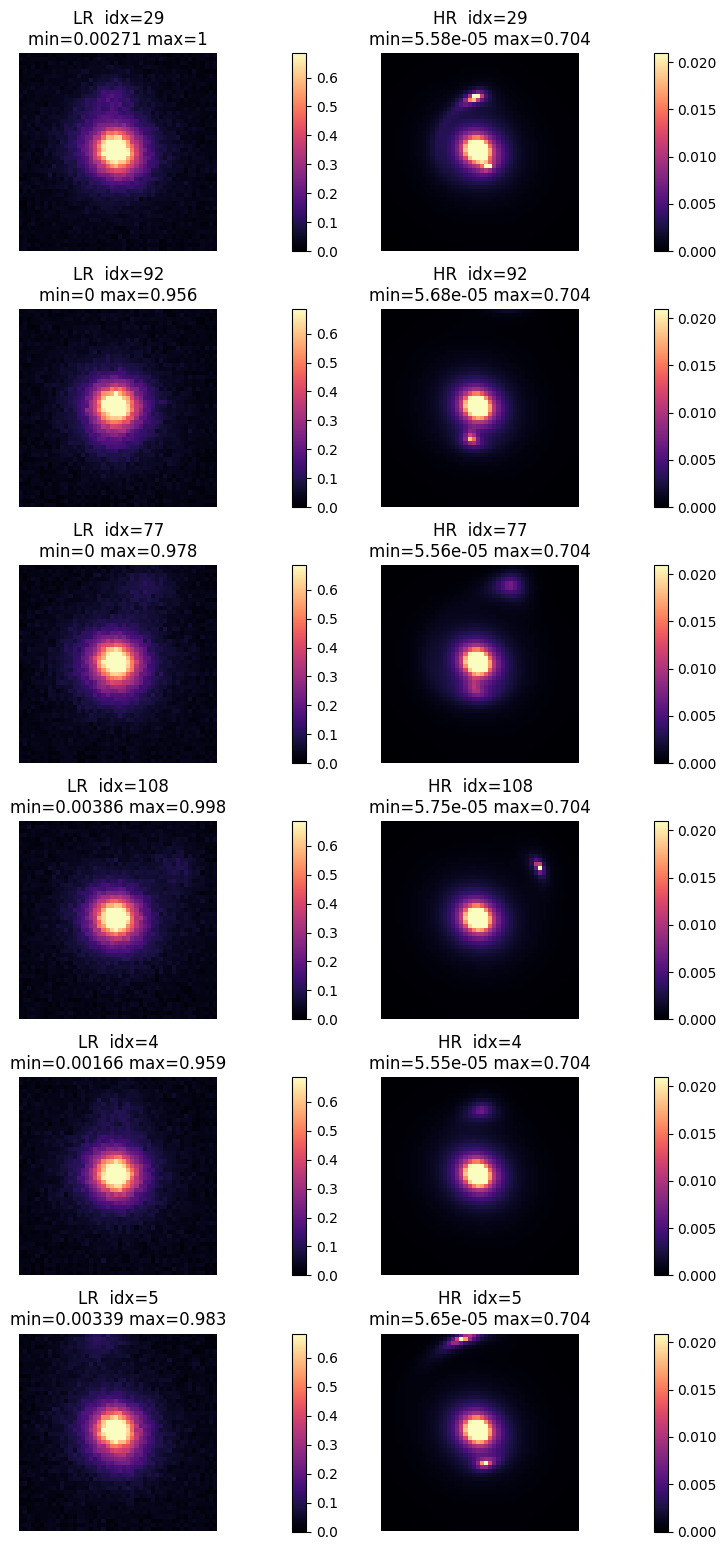

In [9]:
# ==== Visual sanity check: show LR/HR that actually go into training ====
import matplotlib.pyplot as plt
import numpy as np
import torch

@torch.no_grad()
def show_lr_hr_batch(train_loader, n_show=6, vmax_mode="batch_p99"):
    """
    Display n_show samples from a single training batch.
    - Inputs are taken exactly as the DataLoader yields them (LR first, HR second).
    - Assumes LR, HR are in [0,1].
    - vmax_mode: "batch_p99" (percentile-based) or "per_image" (each image gets its own vmax).
    """
    lr, hr = next(iter(train_loader))  # what the training loop actually uses
    lr = lr.cpu()
    hr = hr.cpu()
    B = lr.shape[0]
    n_show = min(n_show, B)

    # choose indices to show
    idxs = torch.randperm(B)[:n_show].tolist()

    # pick display vmin/vmax
    vmin = 0.0
    if vmax_mode == "batch_p99":
        vmax_lr = float(torch.quantile(lr.flatten(), 0.99).item())
        vmax_hr = float(torch.quantile(hr.flatten(), 0.99).item())
    else:
        vmax_lr = None
        vmax_hr = None

    # figure
    fig, axes = plt.subplots(n_show, 4, figsize=(8, 2.6*n_show), gridspec_kw={"width_ratios":[1,0.04,1,0.04]})
    if n_show == 1:
        axes = np.array([axes])  # ensure 2D indexing

    for row, idx in enumerate(idxs):
        lr_img = lr[idx, 0].numpy()  # [H,W]
        hr_img = hr[idx, 0].numpy()  # [H,W]

        if vmax_mode == "per_image":
            vmax_lr_i = np.quantile(lr_img, 0.99)
            vmax_hr_i = np.quantile(hr_img, 0.99)
        else:
            vmax_lr_i = vmax_lr
            vmax_hr_i = vmax_hr

        ax_lr = axes[row, 0]
        im_lr = ax_lr.imshow(lr_img, cmap="magma", vmin=vmin, vmax=vmax_lr_i)
        ax_lr.set_title(f"LR  idx={idx}\nmin={lr_img.min():.3g} max={lr_img.max():.3g}")
        ax_lr.axis("off")
        
        plt.colorbar(im_lr, cax=axes[row, 1])

        ax_hr = axes[row, 2]
        im_hr = ax_hr.imshow(hr_img, cmap="magma", vmin=vmin, vmax=vmax_hr_i)
        ax_hr.set_title(f"HR  idx={idx}\nmin={hr_img.min():.3g} max={hr_img.max():.3g}")
        ax_hr.axis("off")

        # one shared colorbar per row (for HR by default)
        cax = axes[row, 3]
        plt.colorbar(im_hr, cax=cax)

    plt.tight_layout()
    plt.show()

# call it (tweak n_show and vmax_mode if you like)
show_lr_hr_batch(train_loader, n_show=6, vmax_mode="batch_p99")


In [10]:
def model_fingerprint(model):
    with torch.no_grad():
        s = 0.0
        for p in model.parameters():
            s += p.float().abs().sum().item()
    return s


In [11]:
# --- pretrain G (no GAN, no DC) ---
LAMBDA_L1   = 1.0
LAMBDA_SSIM = 0.0     # start at 0; add later if you want
LAMBDA_FLUX = 0.0     # add small like 0.01 later

E_PRE = 40
EPS = 1e-6

G.train()
for ep in range(1, E_PRE+1):
    for lr, hr in train_loader:
        lr = lr.to(DEVICE, non_blocking=True)
        hr = hr.to(DEVICE, non_blocking=True)

        opt_G.zero_grad(set_to_none=True)
        with torch.enable_grad():
            sr_logits = G(lr)                                   # logits
            t_logits  = torch.logit(hr.clamp(EPS, 1 - EPS))     # targets in logit space
            loss_G    = F.smooth_l1_loss(sr_logits, t_logits)   # or F.mse_loss

        loss_G.backward()
        opt_G.step()

    # eval: map to [0,1]
    metrics = eval_metrics(G, val_loader)  # make sure it does sigmoid(G(...)) inside
    print(f"[ep {ep}] Val: MSE={metrics['MSE']:.9f}  MAE={metrics['MAE']:.9f}  "
          f"PSNR={metrics['PSNR']:.4f} dB  SSIM={metrics['SSIM']:.6f}")

[ep 1] Val: MSE=0.000209469  MAE=0.001044627  PSNR=36.7907 dB  SSIM=0.957682
[ep 2] Val: MSE=0.000209781  MAE=0.000858122  PSNR=36.7842 dB  SSIM=0.957819
[ep 3] Val: MSE=0.000191025  MAE=0.000686998  PSNR=37.1915 dB  SSIM=0.962740
[ep 4] Val: MSE=0.000171990  MAE=0.000778791  PSNR=37.6482 dB  SSIM=0.966969
[ep 5] Val: MSE=0.000179997  MAE=0.000640347  PSNR=37.4513 dB  SSIM=0.965259
[ep 6] Val: MSE=0.000171641  MAE=0.000618091  PSNR=37.6592 dB  SSIM=0.967204
[ep 7] Val: MSE=0.000158906  MAE=0.000594523  PSNR=37.9956 dB  SSIM=0.970596
[ep 8] Val: MSE=0.000152345  MAE=0.000541415  PSNR=38.1798 dB  SSIM=0.971728
[ep 9] Val: MSE=0.000135810  MAE=0.000509335  PSNR=38.6787 dB  SSIM=0.974726
[ep 10] Val: MSE=0.000099967  MAE=0.000533898  PSNR=40.0130 dB  SSIM=0.981821
[ep 11] Val: MSE=0.000066768  MAE=0.000406452  PSNR=41.7834 dB  SSIM=0.987645
[ep 12] Val: MSE=0.000022120  MAE=0.000355830  PSNR=46.6922 dB  SSIM=0.994673
[ep 13] Val: MSE=0.000008753  MAE=0.000339571  PSNR=51.0525 dB  SSIM=0.99

In [12]:
# --- Adversarial training (hinge GAN + logit-space pixel loss) ---

use_amp = True  # optional; works fine here
scaler  = torch.amp.GradScaler('cuda', enabled=use_amp)

# weights (good starting points; tweak to taste)
LAMBDA_LOGIT = 1.0       # pixel loss in logit space (Huber/MSE)
LAMBDA_SSIM  = 0.0       # add later if you want; uses [0,1] images
LAMBDA_DC    = 0.05      # PSF/data-consistency on [0,1]
LAMBDA_FLUX  = 0.0       # or small like 1e-2 if you use it
LAMBDA_ADV   = 1e-3      # hinge-G adv weight for G (typical 1e-3 ~ 5e-3)

R1_GAMMA     = 10.0      # common choice for R1 on real
R1_INTERVAL  = 16        # lazy R1 every N steps

EPS = 1e-6

E_ADV = 160
step = 0

out_dir = Path("./out_satgan_gan")
out_dir.mkdir(parents=True, exist_ok=True)

best_psnr = float("-inf")  # put this BEFORE the GAN loop

def _pack_state(epoch, best_psnr):
    return {
        "G": G.state_dict(),
        "D": D.state_dict(),
        "opt_G": opt_G.state_dict(),
        "opt_D": opt_D.state_dict(),
        "scaler": scaler.state_dict() if scaler is not None else None,
        "epoch": epoch,
        "best_psnr": best_psnr,
    }

for ep in range(1, E_ADV + 1):
    G.train(); D.train()

    for lr, hr in train_loader:
        lr = lr.to(DEVICE, non_blocking=True)
        hr = hr.to(DEVICE, non_blocking=True)

        # -------------------------
        # 1) Discriminator step
        # -------------------------
        with torch.no_grad():
            # fake image for D in [0,1]
            sr_fake_01 = torch.sigmoid(G(lr))

        with torch.amp.autocast('cuda', enabled=use_amp):
            real_logits = D(hr)          # hr is already [0,1]
            fake_logits = D(sr_fake_01)  # [0,1]
            loss_D = F.relu(1 - real_logits).mean() + F.relu(1 + fake_logits).mean()

        # Lazy R1 on real
        if step % R1_INTERVAL == 0:
            hr.requires_grad_(True)
            with torch.amp.autocast('cuda', enabled=False):  # full precision for R1 is safer
                r1_logits = D(hr)
                grad = torch.autograd.grad(
                    r1_logits.sum(), hr, create_graph=True, retain_graph=True, only_inputs=True
                )[0]
                r1_pen = grad.pow(2).flatten(1).sum(1).mean()
                loss_D = loss_D + (R1_GAMMA * 0.5) * r1_pen
            hr = hr.detach()

        opt_D.zero_grad(set_to_none=True)
        scaler.scale(loss_D).backward()
        scaler.step(opt_D)
        scaler.update()

        # -------------------------
        # 2) Generator step
        # -------------------------
        with torch.amp.autocast('cuda', enabled=use_amp):
            sr_logits = G(lr)                       # logits (unbounded)
            sr_01     = torch.sigmoid(sr_logits)    # [0,1] branch for adv/DC/SSIM/flux

            # (a) adversarial term (hinge-G)
            g_fake_logits = D(sr_01)
            loss_adv = -g_fake_logits.mean()

            # (b) pixel/logit term (no sigmoid in backprop path)
            t_logits = torch.logit(hr.clamp(EPS, 1 - EPS))
            loss_logit = F.smooth_l1_loss(sr_logits, t_logits)

            # (c) data-consistency / PSF term (works in [0,1] image space)
            # make sure psf_same is differentiable (conv/downsample, no .detach/.data inside)
            loss_dc = F.l1_loss(psf_same(sr_01), lr)

            # (d) optional perception/flux terms (also on [0,1])
            loss_ss = (1 - ms_ssim(sr_01, hr, data_range=1.0)) if LAMBDA_SSIM > 0 else 0.0
            loss_fx = flux_loss(sr_01, hr) if LAMBDA_FLUX > 0 else 0.0

            loss_G = (
                LAMBDA_ADV   * loss_adv +
                LAMBDA_LOGIT * loss_logit +
                LAMBDA_DC    * loss_dc +
                LAMBDA_SSIM  * loss_ss +
                LAMBDA_FLUX  * loss_fx
            )

        opt_G.zero_grad(set_to_none=True)
        scaler.scale(loss_G).backward()
        scaler.step(opt_G)
        scaler.update()

        step += 1

    # ---------- validation (use [0,1]) ----------
    metrics = eval_metrics(G, val_loader)  # must do sr = sigmoid(G(lr)) inside
    print(f"[ep {ep}] "
          f"MSE={metrics['MSE']:.9f}  MAE={metrics['MAE']:.9f}  "
          f"PSNR={metrics['PSNR']:.4f} dB  SSIM={metrics['SSIM']:.6f}")
    
        # ---------- SAVE CHECKPOINTS ----------
    state = _pack_state(ep, best_psnr)

    # always save latest (can overwrite)
    torch.save(state, out_dir / "ckpt_latest.pt")

    # save best by PSNR
    if metrics["PSNR"] > best_psnr:
        best_psnr = metrics["PSNR"]
        state["best_psnr"] = best_psnr
        torch.save(state, out_dir / "ckpt_best.pt")
        print(f"✓ new best PSNR {best_psnr:.4f} — saved ckpt_best.pt")




[ep 1] MSE=0.000001811  MAE=0.000192308  PSNR=60.3254 dB  SSIM=0.998272
✓ new best PSNR 60.3254 — saved ckpt_best.pt
[ep 2] MSE=0.000001972  MAE=0.000176328  PSNR=59.7602 dB  SSIM=0.998424
[ep 3] MSE=0.000001560  MAE=0.000147063  PSNR=61.6359 dB  SSIM=0.998513
✓ new best PSNR 61.6359 — saved ckpt_best.pt
[ep 4] MSE=0.000002109  MAE=0.000198209  PSNR=58.9694 dB  SSIM=0.997934
[ep 5] MSE=0.000001297  MAE=0.000124956  PSNR=63.5325 dB  SSIM=0.998760
✓ new best PSNR 63.5325 — saved ckpt_best.pt
[ep 6] MSE=0.000001552  MAE=0.000162996  PSNR=60.8941 dB  SSIM=0.998690
[ep 7] MSE=0.000001560  MAE=0.000172183  PSNR=60.6532 dB  SSIM=0.998633
[ep 8] MSE=0.000001360  MAE=0.000149723  PSNR=62.3460 dB  SSIM=0.998666
[ep 9] MSE=0.000001283  MAE=0.000122823  PSNR=62.9634 dB  SSIM=0.998814
[ep 10] MSE=0.000001527  MAE=0.000152832  PSNR=60.8116 dB  SSIM=0.998715
[ep 11] MSE=0.000001367  MAE=0.000152357  PSNR=62.4432 dB  SSIM=0.998761
[ep 12] MSE=0.000001264  MAE=0.000125164  PSNR=62.6956 dB  SSIM=0.99886

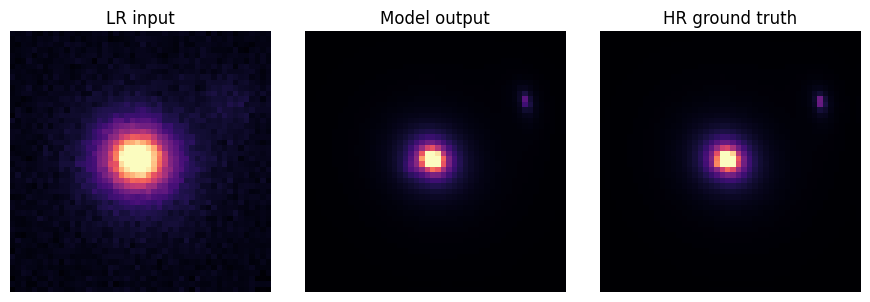

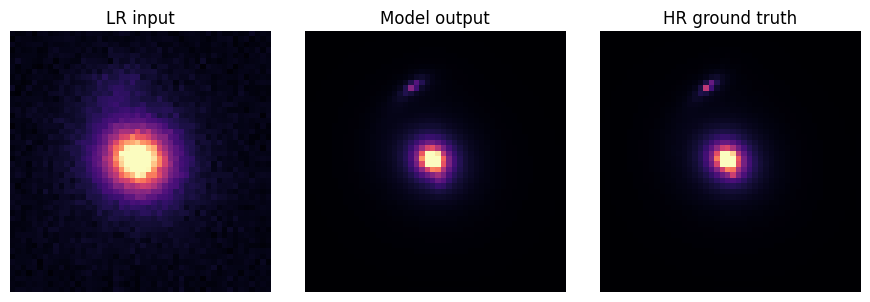

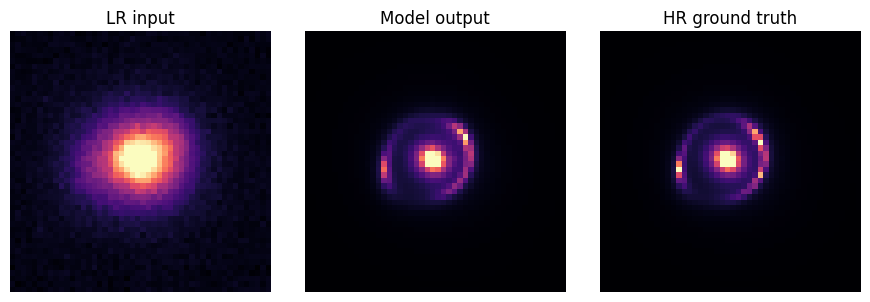

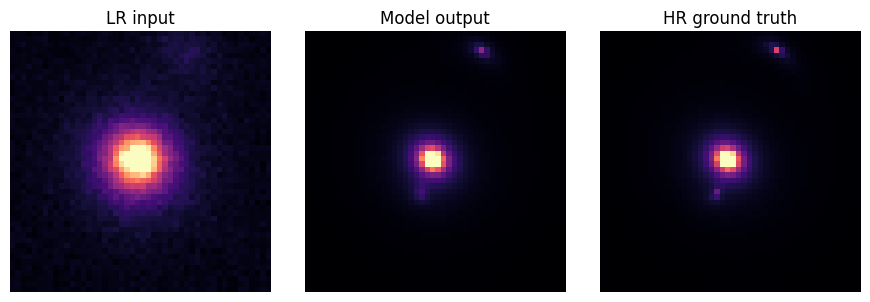

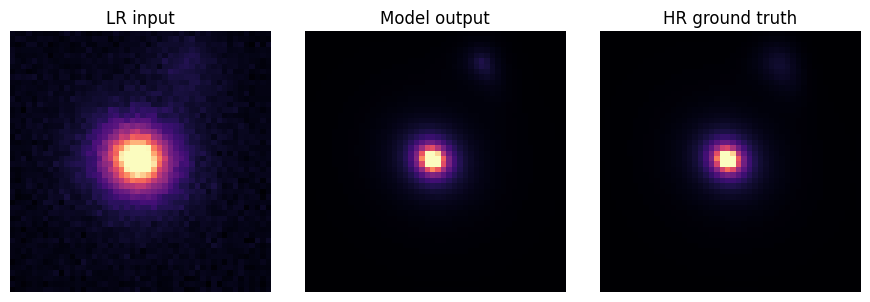

In [13]:
import matplotlib.pyplot as plt
import torch

G.eval()
vmax_lr = 0.7
vmax_hr = 0.05

# grab 5 batches (or just iterate)
num_examples = 5
lr_batch, hr_batch = next(iter(val_loader))
lr_batch, hr_batch = lr_batch.to(DEVICE), hr_batch.to(DEVICE)

with torch.no_grad():
    sr_batch = torch.sigmoid(G(lr_batch))

for i in range(min(num_examples, lr_batch.size(0))):
    lr_img = lr_batch[i,0].cpu().numpy()
    sr_img = sr_batch[i,0].cpu().numpy()
    hr_img = hr_batch[i,0].cpu().numpy()

    fig, axs = plt.subplots(1,3, figsize=(9,3))
    axs[0].imshow(lr_img, cmap="magma", vmin=0, vmax=vmax_lr)
    axs[0].set_title("LR input")
    axs[1].imshow(sr_img, cmap="magma", vmin=0, vmax=vmax_hr)
    axs[1].set_title("Model output")
    axs[2].imshow(hr_img, cmap="magma", vmin=0, vmax=vmax_hr)
    axs[2].set_title("HR ground truth")
    for ax in axs: ax.axis("off")
    plt.tight_layout()
    plt.show()

